In [ ]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))


from typing import List, Tuple, Optional
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from core.s3 import S3AssetManager
from core.viz import  plot_bar

In [5]:
notebook_name = "alcon_production_qa"
s3 = S3AssetManager(notebook_name=notebook_name)

In [8]:
df =  s3.read_excel(
    file="raw/alcon/HISTORIAL PELLET.xlsx", sheet_name="PELET", skiprows=3
)

Reading Excel from: s3://galileo-c4e9a2f1/raw/alcon/HISTORIAL PELLET.xlsx


In [9]:
df["FECHA"] = pd.to_datetime(df["FECHA"])
inicio = pd.Timestamp("2025-05-15")
fin = pd.Timestamp("2025-07-01")


mask = (df["FECHA"] >= inicio) & (df["FECHA"] <= fin)
df["periodo"] = np.where(mask, "periodo (15 Mayo-1 Julio)", "periodo (Otro)")
df["mes"] = df["FECHA"].dt.month
df["semana_anno"] = df["FECHA"].dt.isocalendar().week
df["op"] = df[45698]
df = df[df["op"].notnull()]
df.drop(columns=[45698, 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], inplace=True)

In [10]:
df.shape

(1087, 22)

In [11]:
df["op"].isnull().sum()

0

<Axes: xlabel='semana_anno,mes'>

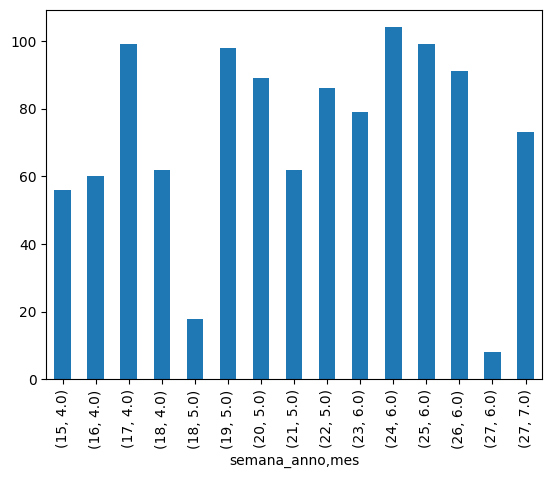

In [12]:
df.groupby(["semana_anno", "mes"]).size().plot(kind="bar")

In [13]:

num_cols = [
    "Ton", "Rend. Ton/hor", "Carga", "Temp.",
    "Presion Acondicionador", "Presion Caldera",
    "Durabilidad", "% de finos",
    "Amp Motor 1", "Amp Motor 2",
    "Tiempo Enfriami."
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

def by_group(group):
    """
    Agrupa los datos y calcula el resumen estadístico incluyendo
    promedios y desviaciones estándar para las variables de proceso.
    """
    resumen = (
    df.groupby(group).agg(
        #op_nunique=("op", "nunique"),
        #ton_sum=("Ton", "sum"),
        rend_ton_hor_mean=("Rend. Ton/hor", "mean"),
        rend_ton_hor_std=("Rend. Ton/hor", "std"),
        #carga_mean=("Carga", "mean"),
        #carga_std=("Carga", "std"),
        temp_mean=("Temp.", "mean"),
        temp_std=("Temp.", "std"),
        durabilidad_mean=("Durabilidad", "mean"),
        durabilidad_std=("Durabilidad", "std"),
        finos_mean=("% de finos", "mean"),
        finos_std=("% de finos", "std"),
        amp1_mean=("Amp Motor 1", "mean"),
        amp1_std=("Amp Motor 1", "std"),
        amp2_mean=("Amp Motor 2", "mean"),
        amp2_std=("Amp Motor 2", "std")

    ).round(2)
)

    return resumen.reset_index()



In [14]:
df_periodo = by_group(group=['periodo'])
s3.save_dataframe(df_periodo, 'summary_alcon.csv')
df_periodo

Saving CSV to: s3://galileo-c4e9a2f1/data/alcon_production_qa/summary_alcon.csv


,periodo,rend_ton_hor_mean,rend_ton_hor_std,temp_mean,temp_std,durabilidad_mean,durabilidad_std,finos_mean,finos_std,amp1_mean,amp1_std,amp2_mean,amp2_std
0,periodo (15 Mayo-1 Julio),3.43,0.88,75.18,30.28,93.17,3.99,2.11,2.43,72.43,25.34,80.27,12.15
1,periodo (Otro),3.51,0.86,69.90,13.32,89.86,19.37,1.83,2.02,76.63,7.67,83.04,7.52


In [15]:


def plot_summary_dashboard(
    df: pd.DataFrame,
    metrics: List[Tuple[str, str]],
    title: str = None,
    colors= ["#1C8074",  "#666666", "#1A494C", "#94AF92", "#E6ECD8", "#C9C9C9"]
):
    """
    Crea un gráfico 2x2 con barras para métricas resumidas y lo guarda como HTML.

    Parámetros:
    - df: DataFrame con los datos.
    - metrics: Lista de tuplas (columna, etiqueta) para graficar.
    - output_path: Ruta del archivo HTML de salida.
    - title: Título general del gráfico (opcional).
    - colors: Lista de colores para las barras.
    """

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[label for _, label in metrics]
    )

    # Añadir barras
    for i, (col, label) in enumerate(metrics):
        row = i // 2 + 1
        col_pos = i % 2 + 1

        fig.add_trace(
            go.Bar(
                x=df[df.columns[0]],
                y=df[col],
                name=label,
                marker_color=colors[i % len(colors)]
            ),
            row=row, col=col_pos
        )

    # Layout general
    fig.update_layout(
        title_text=title,
        showlegend=False,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color="black",
        margin=dict(t=60, b=40, l=40, r=40),
    )

    # Ejes
    for i, (col, label) in enumerate(metrics):
        row = i // 2 + 1
        col_pos = i % 2 + 1
        fig.update_xaxes(
            title_text=df.columns[0],
            showgrid=False,
            linecolor="black",
            tickfont=dict(color="black"),
            title_font=dict(color="black"),
            row=row, col=col_pos
        )
        fig.update_yaxes(
            title_text=label,
            showgrid=False,
            linecolor="black",
            tickfont=dict(color="black"),
            title_font=dict(color="black"),
            row=row, col=col_pos
        )
    return fig


In [16]:
f = plot_summary_dashboard(
    df=df_periodo,
    metrics=[
        ("rend_ton_hor_mean", "Rendimiento Ton/h"),
        ("temp_mean", "Temperatura (°C)"),
        ("durabilidad_mean", "Durabilidad (%)"),
        ("finos_mean", "Finos (%)")
    ],
    title="Resumen de KPIs por periodo"
)
f.show()
s3.save_plotly_html(f, 'summary_dashboard.html')

In [17]:
by_fecha = by_group(group=['FECHA'])
by_fecha

,FECHA,rend_ton_hor_mean,rend_ton_hor_std,temp_mean,temp_std,durabilidad_mean,durabilidad_std,finos_mean,finos_std,amp1_mean,amp1_std,amp2_mean,amp2_std
0,2025-04-10,3.87,0.51,74.93,6.49,1.33,0.84,1.33,0.84,70.89,7.59,75.76,4.84
1,2025-04-11,3.16,1.04,60.54,12.09,1.33,0.34,1.33,0.34,77.00,8.43,83.37,7.31
2,2025-04-12,3.07,1.49,75.64,3.59,94.65,1.65,1.94,2.08,73.48,5.55,80.79,6.23
3,2025-04-14,3.84,0.59,78.09,3.86,94.14,2.23,2.88,2.38,76.58,8.56,84.85,4.81
4,2025-04-15,3.97,0.77,70.42,7.82,91.15,7.92,0.92,0.09,81.99,4.29,90.58,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2025-06-30,3.79,0.16,72.25,4.77,91.92,1.80,1.31,0.33,80.61,11.28,86.86,6.50
67,2025-07-01,3.01,0.70,73.69,8.28,87.76,20.94,1.66,1.27,64.03,10.79,75.97,12.59
68,2025-07-02,3.54,0.78,67.70,8.70,92.60,2.20,2.19,3.37,67.98,10.89,79.78,9.30
69,2025-07-03,3.65,0.52,69.50,10.17,93.47,2.10,1.40,1.02,74.86,9.53,84.33,8.76


In [20]:
df_fecha_dado = by_group(group=["FECHA", "Diametro del dado"])
df_fecha_dado

,FECHA,Diametro del dado,rend_ton_hor_mean,rend_ton_hor_std,temp_mean,temp_std,durabilidad_mean,durabilidad_std,finos_mean,finos_std,amp1_mean,amp1_std,amp2_mean,amp2_std
0,2025-04-10,4.5,3.89,0.52,75.64,6.10,1.40,0.89,1.40,0.89,71.86,6.84,76.22,4.66
1,2025-04-10,6.0,3.60,NaN,65.00,NaN,0.90,NaN,0.90,NaN,57.30,NaN,69.30,NaN
2,2025-04-11,3.0,2.75,1.00,57.25,14.35,1.51,0.23,1.51,0.23,78.42,5.64,84.87,5.47
3,2025-04-11,4.5,4.03,0.52,67.00,6.08,1.00,0.20,1.00,0.20,81.93,9.87,85.80,9.59
4,2025-04-11,6.0,3.45,1.20,64.00,1.41,0.90,0.00,0.90,0.00,62.50,0.99,72.20,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2025-06-30,4.5,3.79,0.16,72.25,4.77,91.92,1.80,1.31,0.33,80.61,11.28,86.86,6.50
91,2025-07-01,4.5,3.01,0.70,73.69,8.28,87.76,20.94,1.66,1.27,64.03,10.79,75.97,12.59
92,2025-07-02,4.5,3.54,0.78,67.70,8.70,92.60,2.20,2.19,3.37,67.98,10.89,79.78,9.30
93,2025-07-03,4.5,3.65,0.52,69.50,10.17,93.47,2.10,1.40,1.02,74.86,9.53,84.33,8.76


In [21]:

def plot_multi_metric_line_dashboard_by_category(
    df: pd.DataFrame,
    date_col: str,
    category_col: str,
    metrics: List[Tuple[str, str]],
    base_colors: Optional[List[str]] = None,
    vrect_range: Optional[Tuple[str, str]] = None,
    title: Optional[str] = None
):
    """
    Genera un gráfico de subplots 2x2 con líneas por categoría para varias métricas.

    Parámetros:
    - df: DataFrame con los datos.
    - date_col: Nombre de la columna de fecha.
    - category_col: Columna categórica para agrupar.
    - metrics: Lista de tuplas (columna, etiqueta del eje Y).
    - output_path: Ruta para guardar el archivo HTML.
    - base_colors: Lista de colores personalizados.
    - vrect_range: Tupla opcional (inicio, fin) para sombrear un rango.
    - title: Título principal del gráfico.
    """

    if base_colors is None:
        base_colors = ['#1C8074', '#94AF92', '#FF5733', '#C70039', '#900C3F']

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[ylabel for _, ylabel in metrics]
    )

    categories = df[category_col].unique()

    for i, (col, ylabel) in enumerate(metrics):
        row = i // 2 + 1
        col_pos = i % 2 + 1

        for j, cat in enumerate(categories):
            df_cat = df[df[category_col] == cat]

            fig.add_trace(
                go.Scatter(
                    x=df_cat[date_col],
                    y=df_cat[col],
                    mode="lines+markers",
                    name=f"{cat}",
                    legendgroup=f"{cat}",
                    showlegend=(i == 0),
                    line=dict(color=base_colors[j % len(base_colors)], width=2)
                ),
                row=row,
                col=col_pos
            )

    # Layout general
    fig.update_layout(
        title=dict(text=title or "Evolución de métricas por categoría", x=0.5, xanchor="center"),
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color="black",
        margin=dict(t=90),
        legend_title_text=category_col
    )

    fig.update_xaxes(showgrid=False, linecolor="black", tickfont=dict(color="black"))
    fig.update_yaxes(showgrid=False, linecolor="black", tickfont=dict(color="black"))

    if vrect_range:
        fig.add_vrect(
            x0=vrect_range[0],
            x1=vrect_range[1],
            fillcolor="LightSalmon",
            opacity=0.3,
            layer="below",
            line_width=0
        )

    for i, (col, ylabel) in enumerate(metrics):
        row = i // 2 + 1
        col_pos = i % 2 + 1
        fig.update_xaxes(title_text="Fecha", row=row, col=col_pos)
        fig.update_yaxes(title_text=ylabel, row=row, col=col_pos)

    return fig

In [22]:
f = plot_multi_metric_line_dashboard_by_category(
    df=df_fecha_dado,
    date_col="FECHA",
    category_col="Diametro del dado",
    metrics=[
        ("rend_ton_hor_mean", "Rendimiento Ton/h"),
        ("temp_mean", "Temperatura (°C)"),
        ("durabilidad_mean", "Durabilidad (%)"),
        ("finos_mean", "Finos (%)")
    ],
    title="Evolución de los Indicadores promedios de Producción por Diámetro de Dado",
    vrect_range=("2025-05-15", "2025-07-01")
)
f.show()
s3.save_plotly_html(f,'summary_line_dashboard_by_diametro_simple_legend.html')

In [23]:
f = plot_multi_metric_line_dashboard_by_category(
    df=df_fecha_dado,
    date_col="FECHA",
    category_col="Diametro del dado",
    metrics=[
        ("rend_ton_hor_std", "STD Rendimiento Ton/h"),
        ("temp_std", "STD Temperatura (°C)"),
        ("durabilidad_std", "STD Durabilidad (%)"),
        ("finos_std", "STD Finos (%)")
    ],
    title="Evolución de la Dispersión de los Indicadores de Producción por Diámetro de Dado",
    vrect_range=("2025-05-15", "2025-07-01")
)
f.show()
s3.save_plotly_html(f, 'summary_line_dashboard_by_diametro_simple_legend_std.html')